In [4]:
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DPMSolverMultistepScheduler, DDIMScheduler
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [5]:

class Sketch2ImgDataset(Dataset):
    def __init__(self, data_root):
        self.fmnist_dataset = torchvision.datasets.FashionMNIST(data_root)
        self.classes = self.fmnist_dataset.classes
    
    def __len__(self):
        return len(self.fmnist_dataset)

    def __getitem__(self, index):
        img = self.fmnist_dataset.data[index]
        label = self.fmnist_dataset.targets[index]
        sketch =  torch.from_numpy(cv2.Canny(img.numpy(), 200, 200))

        # to shape: [1, h, w]
        img = img.unsqueeze(0).float()
        sketch = sketch.unsqueeze(0).float()

        img = self.normalize(img)
        sketch = self.normalize(sketch)

        return img, sketch, label    
    def normalize(self, x):
        # map x to -1 < x < 1
        # I'm doing normalization with zero understanding :o
        x /= 255
        x = torchvision.transforms.Normalize(0.5, 0.5)(x)
        return x

In [6]:
batch_size = 64
num_train_timesteps = 1000
lr = 1e-5
num_epochs = 10
device = "cuda"
train_dataset_rate = 1

# Create a model
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=2,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
).to(device)

scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
dataset = Sketch2ImgDataset("./data/FashionMNIST")
dataset_len = int(len(dataset) * train_dataset_rate)
dataset, _ = torch.utils.data.random_split(dataset, [dataset_len, len(dataset) - dataset_len])

dataloader = DataLoader(dataset, batch_size, shuffle=True)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
for e in range(num_epochs):
    for step, (img, sketch, _) in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()

        img = img.to(device)
        sketch = sketch.to(device)
        noise = torch.randn(img.shape).to(device)
        bs = img.shape[0]

        timesteps = torch.randint(0, scheduler.num_train_timesteps, (bs, ), device=device).long()
        noisy_img = scheduler.add_noise(img, noise, timesteps)

        x = torch.cat([noisy_img, sketch], dim=1).cuda()

        noise_pred = model(x, timesteps).sample

        loss = F.mse_loss(noise_pred, noise)
        # loss.backward(loss) ? 
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

100%|██████████| 938/938 [03:48<00:00,  4.11it/s]


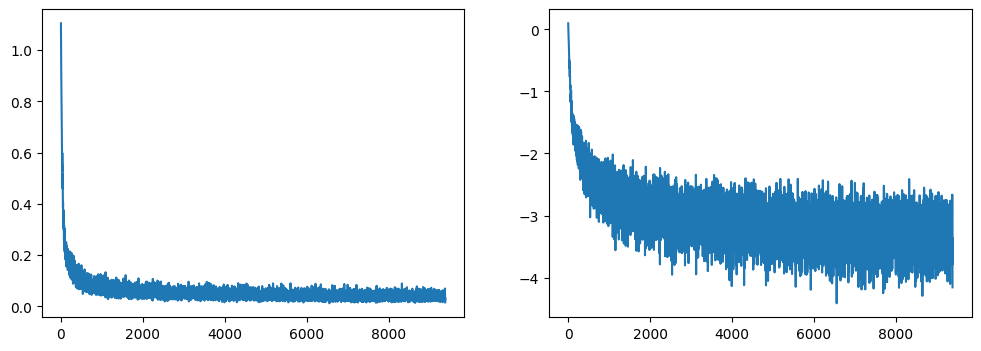

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [8]:
torch.save(model, './model/10epochs.pth')

In [64]:
print(scheduler.num_train_timesteps)

AttributeError: 'NoneType' object has no attribute 'num_train_timesteps'

100%|██████████| 10/10 [00:00<00:00, 17.95it/s]


' \nprint(noise.shape)\nprint(sketch.shape)\nx = torch.cat([noise, sketch], dim=0).unsqueeze(0).cuda()\ntimesteps = torch.tensor([0]).cuda()\nprint(x.shape)\nwith torch.no_grad():\n    pred = model(x, 0).sample\nprint(pred.device, timesteps.device, x.device)\nsample = scheduler.step(pred,0,x).pred_original_sample\nplt.imshow(sample[0][0].to("cpu"))\n'

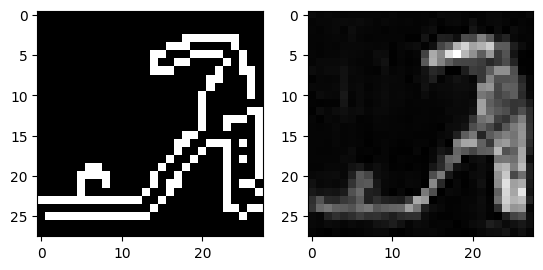

In [46]:
def prediction(model,scheduler, sketch, device="cuda"):
    model.to(device)
    sketch = sketch.unsqueeze(0).to(device)
    sample = torch.randn(sketch.shape).to(device)
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        with torch.no_grad():
            x = torch.cat([sample, sketch], dim=1).to(device)
            residual = model(x, t).sample
        sample = scheduler.step(residual, t, sample).prev_sample
    return sample

img, sketch, lable = next(iter(dataloader))
img = img[0]
sketch = sketch[0]
scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)
scheduler.set_timesteps(10)
sample = prediction(model,scheduler, sketch, "cpu")
fig, axs = plt.subplots(1,2)

axs[0].imshow(sketch[0], cmap="gray")
axs[1].imshow(sample[0][0].cpu(), cmap="gray")
""" 
print(noise.shape)
print(sketch.shape)
x = torch.cat([noise, sketch], dim=0).unsqueeze(0).cuda()
timesteps = torch.tensor([0]).cuda()
print(x.shape)
with torch.no_grad():
    pred = model(x, 0).sample
print(pred.device, timesteps.device, x.device)
sample = scheduler.step(pred,0,x).pred_original_sample
plt.imshow(sample[0][0].to("cpu"))
"""

100%|██████████| 1000/1000 [00:11<00:00, 90.73it/s]


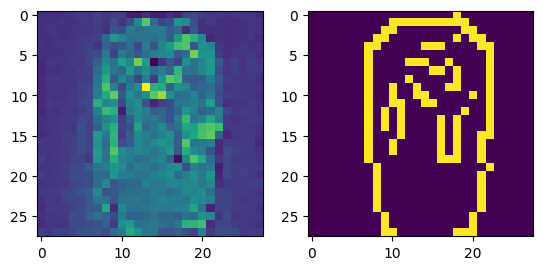

In [122]:
model = torch.load("./model/test_model_weight.pth").cuda()
img, sketch, lable = next(iter(dataloader))
img = img[0]
sketch = sketch[0]
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
scheduler.set_timesteps(1000)
sample = prediction(model,scheduler, sketch)
fig, axs = plt.subplots(1,2)

axs[0].imshow(sample[0][0].cpu())
axs[1].imshow(sketch[0])